# Avaliação de Modelos de Regressão

### Dataset
**'House-Prices'**. Estimar o valor das casas com base em suas características (*n_quartos*, *n_banheiros*, *area_util*, *area_externa*, *n_andares*, *estado_da_casa*, *ano_construcao*, *ano_renovacao*, *localização*, entre outras)

### Proposta
Realizar a comparação de modelos de regressão utilizando validação cruzada a fim de selecionar aqueles que apresentam melhor precisão

## Funcionamento
Na função **create_test_model**, define-se os modelos a serem avaliados com os parâmetros desejados, e atribui-se um nome de identificação a cada um deles.

Em seguida, na seção *Código*, adiciona-se os nomes atribuídos, no passo anterior, ao dicionário **all_models** e utiliza-se a variável **use_models** para selecionar os modelos que se deseja comparar.

Por fim, o algoritmo oferece 3 respostas de saída:

1. **Arquivo csv** com todos os resultados obtidos, caso se deseje fazer outra análise independente. O nome do arquivo a ser gerado pode ser definido alterando-se a variável *nome_arquivo*;
2. **Gráfico** para visualização gráfica da comparação dos valores obtidos;
3. **DataFrame** *average_result* para exibição da média final em forma de tabela

In [104]:
# =====   Importação das Bibliotecas   ===== #
from pandas import read_csv, DataFrame, Series
from numpy import zeros, array
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

# Desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Criação e Teste dos modelos escolhidos
# Definir as opções de modelos disponiveis que se deseja comparar
def create_test_model(regressor, index_train, index_test):
    if regressor == 'regressao':
        modelo = LinearRegression()
    
    elif regressor == 'arvore':
        modelo = DecisionTreeRegressor(random_state=1)
    
    elif regressor == 'forest':
        modelo = RandomForestRegressor(n_estimators=40, random_state=0)
    
    elif regressor == 'svm':
        modelo = SVR(kernel='rbf', C=2.0, gamma='auto')
    
    elif regressor == 'rna':
        modelo = MLPRegressor(max_iter=1000, tol=0.000001, solver='adam',
                           hidden_layer_sizes=(9,9))
    else:
        raise NameError ('Modelo escolhido nao esta na base de dados')
    
    modelo.fit(previsores[index_train], classe[index_train])
    previsoes = modelo.predict(previsores[index_test])
    previsoes = scaler.inverse_transform(previsoes)
    
    score = modelo.score(previsores[index_test], classe[index_test])

    return previsoes, score

In [1]:
# Avaliação da precisão dos modelos
def avalia_modelos(previsores, classe, regressor, n_seed, n_folds=10):
    print('\nRegressor: {}'.format(regressor.title()))
    
    resultado = []
    for seed in range(n_seed):
        kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
        
        precisao = []
        for i_train, i_test in kfold.split(previsores, zeros(shape=(classe.shape[0], 1))):
            # Criacao e Teste do modelo
            previsoes, score = create_test_model(regressor, i_train, i_test)
            
            
            # Avaliacao do modelo
            erro_medio = -mean_absolute_error(scaler.inverse_transform(classe[i_test]), previsoes)
            precisao.append([score, erro_medio]) # score = correlacao
        
        precisao = array(precisao)
        resultado.append(precisao.mean(axis=0))
        print("seed {}: {:.5f} / ${:.2f}".format(seed, precisao.mean(axis=0)[0], -precisao.mean(axis=0)[1]))
    
    return resultado

In [121]:
# Armazena em disco (arquivo csv) os resultados obtivos a medida que realiza a avaliação
def create_file(resultado, modelo):
    global result_dataframe
    colunas = ['seed', '{}_score'.format(modelo), '{}_erro'.format(modelo)]
    
    vetor = []
    for i in range(len(resultado)):
        vetor.append([i, resultado[i][0], resultado[i][1]])
    vetor = DataFrame(vetor, columns=colunas)
    
    result_dataframe = result_dataframe.merge(vetor, on='seed')
    
    colunas = list(result_dataframe.columns)
    arquivo = DataFrame(result_dataframe, columns=colunas)
    arquivo.to_csv(nome_arquivo, index=False)

In [3]:
# Função a ser chamada pelo usuário que da inicio ao processo de avaliação dos modelos
def executa_avaliacao(seeds, use_models):
    global model_result, model_name
    
    for modelo in use_models:
        model_name.append(all_models[modelo].title())
        result = avalia_modelos(previsores, classe, regressor=all_models[modelo], n_seed=seeds)
        model_result.append(result)
        average_result[all_models[modelo].title()] = Series(array(result).mean(axis=0))
        
        create_file(result, modelo=all_models[modelo].title())
    
    average_result.sort_values(by=0, axis=1, ascending=False, inplace=True)
    average_result.index = ['score', 'erro_medio']

In [4]:
# Visualização gráfica da média dos resultados de cada modelo
def view_accuracy():
    fig, ax1 = plt.subplots(figsize=(9,6))
    ax1.plot(average_result.columns, average_result.loc['score'], color='b', marker='o')
    ax1.set_ylabel('Score', color='b')
    for lb in ax1.get_yticklabels():
        lb.set_color('b')
    plt.ylim(top=max(average_result.loc['score'])+0.025)
    plt.grid(axis='y', linewidth="0.5")
    
    ax2 = ax1.twinx()
    ax2.plot(average_result.columns, average_result.loc['erro_medio'], color='red', marker='o')
    plt.yticks(list(range(round(min(average_result.loc['erro_medio'])/1000)*1000,
                          round(max(average_result.loc['erro_medio'])/1000)*1000, 5000)))
    ax2.set_ylabel('Erro Medio', color='red')
    for lb in ax2.get_yticklabels():
        lb.set_color('red')

    plt.title("Score e Erro Medio")

## Seção: Código

In [131]:
# Importação da base de dados e pre processamento dos dados
base = read_csv("house_prices.csv")

previsores = base.iloc[:, 3:19].values
classe = base.iloc[:, 2:3].values

scaler = StandardScaler()
previsores = scaler.fit_transform(previsores)
classe = scaler.fit_transform(classe)

In [132]:
# =====   Seleção dos modelos a utilizar   ===== #
# Selecionar os modelos alterando a variável use_models
all_models = {1: 'regressao', 2: 'arvore', 3: 'forest', 4: 'svm', 5: 'rna'}
use_models = [1, 2, 3, 4, 5]

# nome do arquivo a serem salvos os resultados
nome_arquivo = 'resultado_houseprice.csv'

### Execução

In [135]:
# Criacao do dataframe que armazenara os resultados
seeds = 10
result_dataframe = DataFrame(list(range(seeds)), columns=['seed'])
average_result = DataFrame()

In [136]:
# =====   Coleta dos resultados e Criação do arquivo csv   ===== #
print("Resultados: (score / erro_medio) ")
model_result = []
model_name = []

# Coleta os resultados associando-os aos respectivos modelos e Armazena-os em disco em formato csv
executa_avaliacao(seeds, use_models)

# para teste utilizando 1 unico modelo:
#executa_avaliacao(seeds, [3])

Resultados: (score / erro_medio) 

Regressor: Regressao
seed 0: 0.69683 / $126290.42
seed 1: 0.69839 / $126276.38
seed 2: 0.69705 / $126188.45
seed 3: 0.69756 / $126274.94
seed 4: 0.69637 / $126180.23
seed 5: 0.69616 / $126223.83
seed 6: 0.69723 / $126203.86
seed 7: 0.69699 / $126246.43
seed 8: 0.69729 / $126237.24
seed 9: 0.69749 / $126168.82

Regressor: Arvore
seed 0: 0.73701 / $98395.98
seed 1: 0.73205 / $98663.44
seed 2: 0.76924 / $96233.53
seed 3: 0.75758 / $96306.00
seed 4: 0.74779 / $97577.93
seed 5: 0.76198 / $96605.28
seed 6: 0.75922 / $96177.56
seed 7: 0.74149 / $97788.07
seed 8: 0.75006 / $97127.12
seed 9: 0.75068 / $97122.44

Regressor: Forest
seed 0: 0.87502 / $69431.89
seed 1: 0.87867 / $69103.96
seed 2: 0.87569 / $69382.62
seed 3: 0.87826 / $68695.32
seed 4: 0.87839 / $69189.88
seed 5: 0.87556 / $68903.85
seed 6: 0.87781 / $69117.21
seed 7: 0.87575 / $69268.35
seed 8: 0.87775 / $69087.73
seed 9: 0.87417 / $69433.92

Regressor: Svm
seed 0: 0.78823 / $80994.90
seed 1: 0.79

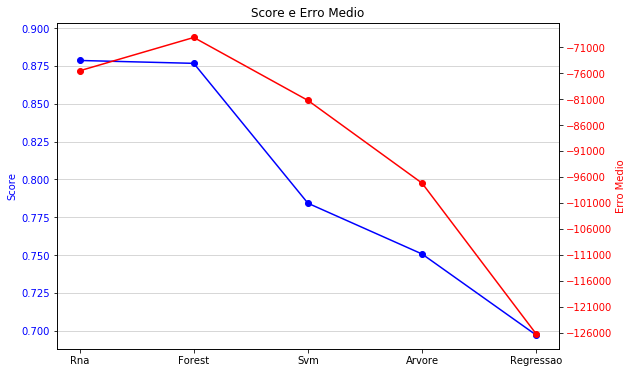

In [137]:
# Visualização Gráfica das Precisões
view_accuracy()

In [138]:
average_result

,Rna,Forest,Svm,Arvore,Regressao
score,0.878609,0.876707,0.784258,0.750709,0.697137
erro_medio,-75575.069860,-69161.472591,-81276.291487,-97199.735151,-126229.058843


In [ ]:
# Regressores com melhores resultados:
# RNA e RandomForest